<a href="https://colab.research.google.com/github/ben-du1/Gen-Z-Score-DataJam-Project-2025/blob/main/V2_Gen_Z_Score_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mordredcommunity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 10.0 MB/s eta 0:00:00


In [204]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from google.colab import drive
import seaborn as sns
import pandas as pd
from sklearn import svm,preprocessing,metrics,linear_model
from sklearn.preprocessing import StandardScaler
from mordred import Calculator,descriptors
from rdkit import Chem
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/theochem/B3DB

Cloning into 'B3DB'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 284 (delta 8), reused 3 (delta 1), pack-reused 265 (from 1)
Receiving objects: 100% (284/284), 162.98 MiB | 22.46 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [ ]:
# cleaning null/extra columns

data = pd.read_csv("/content/B3DB/B3DB/B3DB_classification_extended.tsv.gz", sep="\t", compression="gzip", low_memory=False)
data.drop(columns=['comments','NO.',
 'compound_name',
 'IUPAC_name',
 'CID',
 'Inchi',
 'reference',
 'group','threshold'],inplace=True)
res = data.columns[data.isnull().all(0)]
data.drop(columns=res,inplace=True)

In [ ]:
raw_data = data

In [ ]:
features = raw_data.iloc[:,3:]
target = raw_data.iloc[:,2]
target[target=="BBB+"] = 1
target[target=="BBB-"] = 0

<ipython-input-182-f7a3f24e9b18>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target=="BBB+"] = 1
<ipython-input-182-f7a3f24e9b18>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target=="BBB-"] = 0


In [ ]:
# imputation of missing values

imputer = KNNImputer(n_neighbors=2, weights="uniform",missing_values=np.nan)
imputed_features = imputer.fit_transform(features,y=target)

In [ ]:
raw_data.iloc[:,2] = target
raw_data.iloc[:,3:] = imputed_features


In [ ]:
pre_l1_data = raw_data

In [ ]:
total_cols = pre_l1_data.columns
numeric_cols = total_cols[3:]

desc_data = pre_l1_data.iloc[:,:3]

pre_l1_features = np.array(pre_l1_data.iloc[:,3:])
pre_l1_targets = np.array(pre_l1_data.iloc[:,2]).reshape(-1,1)

In [ ]:
# l1 regularization

lasso = Lasso(alpha=0.1)
lasso.fit(pre_l1_features,pre_l1_targets)
selected_features = np.where(lasso.coef_ != 0)[0]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.094e+02, tolerance: 1.810e-01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
data_selected = pre_l1_features[:,selected_features]
df_selected = pd.DataFrame(data_selected,columns=numeric_cols[selected_features])

df = pd.concat([desc_data,df_selected],axis=1)

In [5]:
# to skip preprocessing run
# df.to_csv("/content/drive/MyDrive/v3postL1data.csv",index=False)
df = pd.read_csv("/content/drive/MyDrive/v3postL1data.csv")

l1_data = df
l1_data = l1_data.sample(frac=1)
x_cols = l1_data.columns[3:]

In [111]:
l1_data = np.array(l1_data)

r,c = l1_data.shape
l1_train = l1_data[:5600]
l1_test = l1_data[5600:]

x_train = np.array(l1_train[:,3:],dtype="float32")
y_train = np.array(l1_train[:,2],dtype="float32")

scaler = StandardScaler()
scaler.fit(x_train)

x_test = np.array(l1_test[:,3:],dtype="float32")
y_test = np.array(l1_test[:,2],dtype="float32")


In [236]:
# model training

clf = svm.SVC(kernel="rbf",gamma=0.1, C=10)
x_train = preprocessing.scale(x_train)
x_test = preprocessing.scale(x_test)

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

clf.fit(x_train[:,:],y_train)

y_pred = clf.predict(x_test[:700,:])
print(abs(y_pred-y_test[:700]).sum())


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


74.0


In [131]:
# predicting off only smiles

calc = Calculator(descriptors,ignore_3D=True)
mol = Chem.MolFromSmiles('C1=CC(=C(C=C1CCN)O)O')
moldf = calc.pandas([mol])
moldf = moldf[x_cols]
moldf = moldf.apply(pd.to_numeric, errors="coerce").fillna(0)
pd.set_option('display.max_columns', 10000)

moldf = scaler.transform(np.array(moldf))

clf.predict(moldf)

100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


array([ 0.000], dtype=float32)

                0
count  131.000000
mean     0.055541
std      0.067704
min      0.000258
25%      0.016781
50%      0.033804
75%      0.058768
max      0.281906
              0
count  4.000000
mean   0.278310
std    0.002949
min    0.275300
25%    0.276287
50%    0.278017
75%    0.280040
max    0.281906


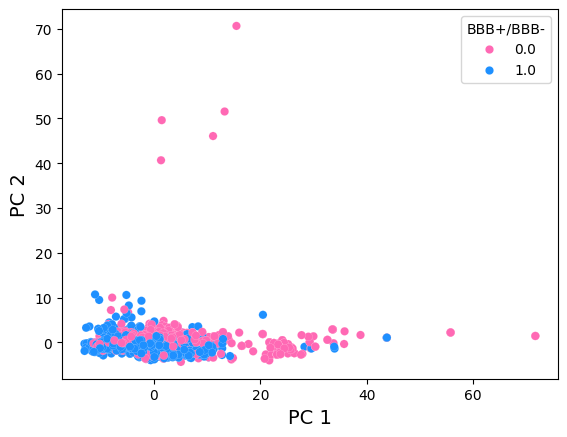

In [235]:
# finding pc1 & pc2 using PCA

points = 2000

pca = PCA(n_components=2)
embedded = pca.fit_transform(x_test)
pca_c = abs(pca.components_)
pc1_w = pca_c[0]
pc2_w = pca_c[1]

print(pd.DataFrame(pc2_w).describe())
print(pd.DataFrame(np.partition(pc2_w, -4)[-4:]).describe())

pca_df =pd.DataFrame({"PCA_1":embedded[:points,0],"PCA_2":embedded[:points,1],"BBB+/BBB-":y_test[:points]})

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(pca_df['PCA_1'],pca_df['PCA_2'],pca_df['PCA_3'],c=['green' if bbb == 1 else 'red' for bbb in pca_df['BBB+/BBB-']],cmap=pca_df['BBB+/BBB-'],s=60)
sns.scatterplot(data=pca_df, x="PCA_1", y="PCA_2",
                hue="BBB+/BBB-",
                palette=sns.color_palette(["hotpink", "dodgerblue"]),
                linewidth=0.1,
                )
plt.xlabel("PC 1", fontsize=14)
plt.ylabel("PC 2", fontsize=14)

# plt.ylim(-5, 5)
# plt.xlim(-5,5)
plt.show()

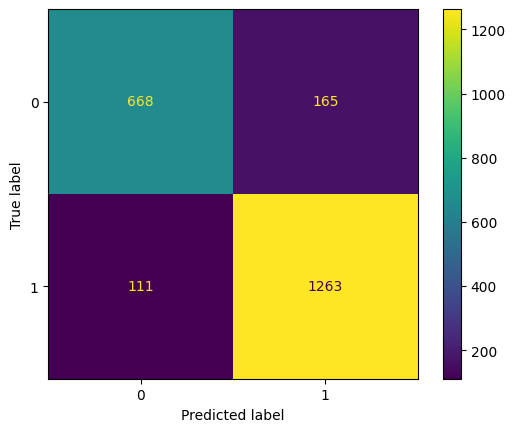

In [ ]:
# confusion matrix

confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()